In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as sla

def schrodinger2D(xmin, xmax, Nx, ymin, ymax, Ny, Vfun2D, params,
                  neigs, E0 = 0.0, findpsi = False):
    x = np.linspace(xmin, xmax, Nx)
    dx = x[1] - x[0]
    y = np.linspace(ymin, ymax, Ny)
    dy = y[1] - y[0]

    V = Vfun2D(x, y, params)

    # Create the 2D Hamiltonian matrix
    # First, the derivatives in the x direction.
    # Note that instead of using arrays, we use sparse matrices
    # in order to reduce computational resource consumption.
    Hx = sparse.lil_matrix(2 * np.eye(Nx))
    for i in range(Nx - 1):
        Hx[i, i + 1] = -1
        Hx[i + 1, i] = -1
    Hx = Hx / (dx ** 2)
    # Next, the derivatives in the y direction.
    Hy = sparse.lil_matrix(2 * np.eye(Ny))
    for i in range(Ny - 1):
        Hy[i, i + 1] = -1
        Hy[i + 1, i] = -1
    Hy = Hy / (dy ** 2)
    # Combine both x and y Hilbert spaces using Kronecker products.
    Ix = sparse.lil_matrix(np.eye(Nx))
    Iy = sparse.lil_matrix(np.eye(Ny))
    H = sparse.kron(Iy, Hx) + sparse.kron(Hy, Ix)

    # Re-convert to sparse matrix lil form.
    H = H.tolil()
    # And add the potential energy.
    for i in range(Nx * Ny):
        H[i, i] = H[i, i] + V[i]

    # Convert to sparse matrix csc form,
    # and solve the eigenvalue problem
    H = H.tocsc()
    [evl, evt] = sla.eigs(H, k = neigs, sigma = E0)

    if findpsi == False:
        return evl
    else:
        return evl, evt, x, y

In [ ]:
def eval_wavefunctions(xmin, xmax, Nx,
                       ymin, ymax, Ny,
                       Vfun, params, neigs, E0, findpsi):

    H = schrodinger2D(xmin, xmax, Nx, ymin, ymax, Ny,
                      Vfun, params, neigs, E0, findpsi)
    # Get eigen energies
    evl = H[0]
    indices = np.argsort(evl)
    print("Energy eigenvalues:")
    for i,j in enumerate(evl[indices]):
        print("{}: {:.2f}".format(i + 1, np.real(j)))
    # Get eigen wave functions
    evt = H[1]
    plt.figure(figsize = (8, 8))
    # Unpack the vector into 2 dimensions for plotting:
    for n in range(neigs):
        psi = evt[:, n]
        PSI = oneD_to_twoD(Nx, Ny, psi)
        PSI = np.abs(PSI)**2
        plt.subplot(2, int(neigs/2), n + 1)
        plt.pcolormesh(np.flipud(PSI), cmap = 'jet')
        plt.axis('equal')
        plt.axis('off')
    plt.show()

In [ ]:
def twoD_to_oneD(Nx, Ny, F):
    # From a 2D matrix F return a 1D vector V.
    V = np.zeros(Nx * Ny)
    vindex = 0
    for i in range(Ny):
        for j in range(Nx):
            V[vindex] = F[i, j]
            vindex = vindex + 1
    return V

def oneD_to_twoD(Nx, Ny, psi):
    # From a 1D vector psi return a 2D matrix PSI.
    vindex = 0
    PSI = np.zeros([Ny, Nx], dtype='complex')
    for i in range(Ny):
        for j in range(Nx):
            PSI[i, j] = psi[vindex]
            vindex = vindex + 1
    return PSI

In [ ]:
def Vfun(X, Y, params):
    R = params[0] # stadium radius
    L = params[1] # stadium length
    V0 = params[2] # stadium wall potential
    # Stadium potential function.
    Nx = len(X)
    Ny = len(Y)
    [x, y] = np.meshgrid(X, Y)
    F = np.zeros([Ny, Nx])
    for i in range(Nx):
        for j in range(Ny):
            if abs(X[i]) == R or abs(Y[j]) == R + 0.5 * L:
                F[j, i] = V0
            cond_0 = (abs(Y[j]) - 0.5 * L) > 0
            cond_1 = np.sqrt((abs(Y[j])-0.5*L)**2 + X[i]**2) >= R
            if cond_0 and cond_1:
                F[j, i] = V0
    # Fold the 2D matrix to a 1D array.
    V = twoD_to_oneD(Nx, Ny, F)
    return V

In [ ]:
def stadium_wavefunctions_plot(R = 1, L = 2, V0 = 1e6,
                               neigs = 6, E0 = 500):
    # R = stadium radius
    # L = stadium length
    # V0 = stadium wall potential
    ymin = -0.5 * L - R
    ymax = 0.5 * L + R
    xmin = -R
    xmax = R
    params = [R, L, V0]
    Ny = 250
    Nx = int(Ny * 2 * R / (2.0 * R + L))
    eval_wavefunctions(xmin, xmax, Nx, ymin, ymax, Ny, Vfun, params, neigs, E0, findpsi = True)

Energy eigenvalues:
1: 496.55
2: 497.78
3: 499.35
4: 500.01
5: 501.76
6: 502.40


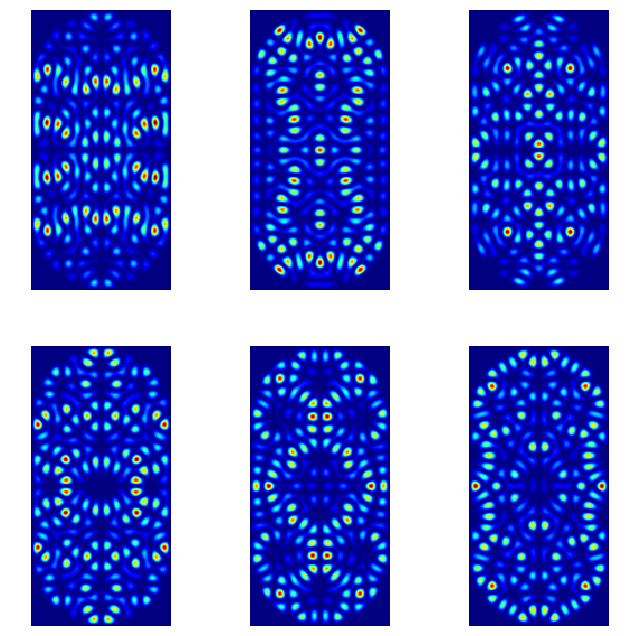

In [ ]:
stadium_wavefunctions_plot(1, 2, 1e6, 6, 500)

Energy eigenvalues:
1: 994.53
2: 999.86
3: 1000.09
4: 1001.17
5: 1001.55
6: 1002.71


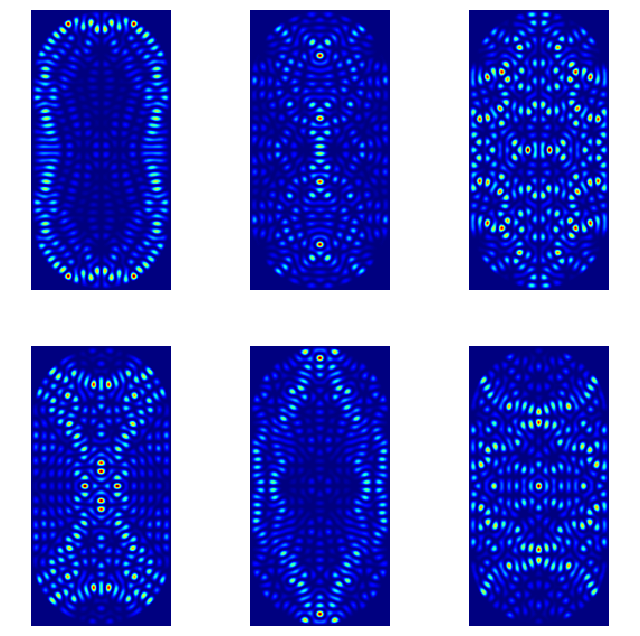

In [ ]:
stadium_wavefunctions_plot(1, 2, 1e6, 6, 1000)

Energy eigenvalues:
1: 95.75
2: 98.76
3: 101.19
4: 101.63
5: 104.17
6: 105.45


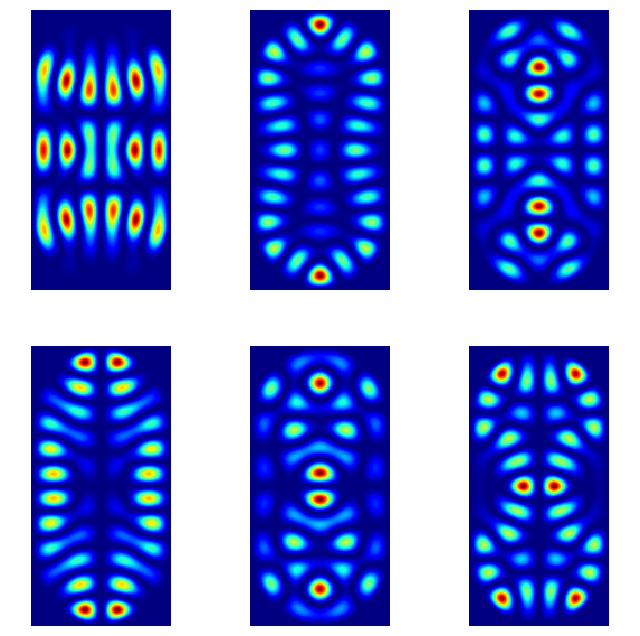

In [ ]:
stadium_wavefunctions_plot(1, 2, 1e6, 6, 100)

In [ ]:
def rk4(t0, t1, y0, ydot_fun, params):
    # This function implements the Runge-Kutta equations k1-k4.
    dt = t1 - t0
    k1 = dt * ydot_fun(y0, t0, params)
    k2 = dt * ydot_fun(y0 + 0.5 * k1, t0 + dt * 0.5, params)
    k3 = dt * ydot_fun(y0 + 0.5 * k2, t0 + dt * 0.5, params)
    k4 = dt * ydot_fun(y0 + k3, t0 + dt, params)
    y1 = y0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
    return y1